In [2]:
# Mount Google Drive (update path if needed)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Install required packages
!pip install -Uqq fastai timm

from fastai.vision.all import *
import torch
from torch import nn
from sklearn.utils.class_weight import compute_class_weight
from fastai.callback.mixup import MixUp

In [4]:
# Set data path (update to your folder location)
DATA_PATH = Path('/content/drive/MyDrive/Satya_prompt/Data-Brand')  # Updated path!

# Verify data structure
print("Classes found:", os.listdir(DATA_PATH))

Classes found: ['Amul_SnT', 'ButterMilk', 'Amul_Taaza', 'Amul_Tspecial', 'Amul_Shakti', 'Amul_Gold', 'Amul_Chai_Mazza']


📊 Image Count per Class:
Amul_Chai_Mazza: 326
Amul_Gold      : 326
Amul_Shakti    : 326
Amul_SnT       : 326
Amul_Taaza     : 326
Amul_Tspecial  : 326
ButterMilk     : 326


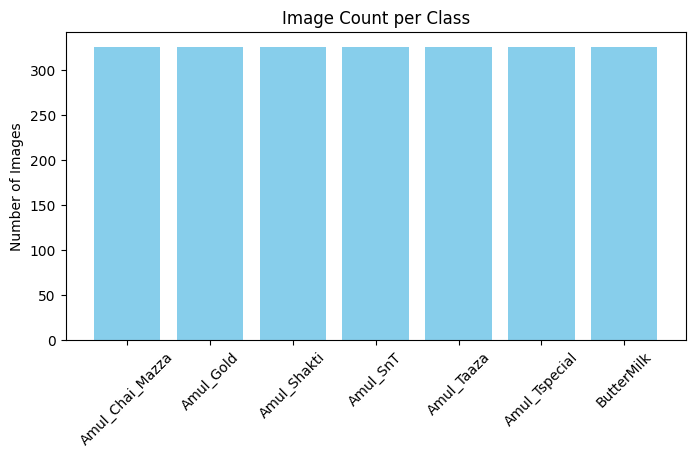

In [5]:
from pathlib import Path
import os
from collections import Counter
import matplotlib.pyplot as plt

# Path to your dataset (change if needed)
dataset_path = Path("/content/drive/MyDrive/Satya_prompt/Data-Brand")

# Count images per class
class_counts = {}
for cls in sorted(os.listdir(dataset_path)):
    class_dir = dataset_path / cls
    if class_dir.is_dir():
        class_counts[cls] = len(list(class_dir.glob("*.*")))

# Display counts
counts = list(class_counts.values())
classes = list(class_counts.keys())
print("📊 Image Count per Class:")
for cls, count in class_counts.items():
    print(f"{cls:15s}: {count}")

# Plot bar chart
plt.figure(figsize=(8,4))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Image Count per Class")
plt.xticks(rotation=45)
plt.ylabel("Number of Images")
plt.show()


In [6]:
# Calculate class weights for imbalanced data
print(classes)
print(counts)

torch.backends.cudnn.benchmark = True

['Amul_Chai_Mazza', 'Amul_Gold', 'Amul_Shakti', 'Amul_SnT', 'Amul_Taaza', 'Amul_Tspecial', 'ButterMilk']
[326, 326, 326, 326, 326, 326, 326]


In [7]:
# # DataBlock with balanced sampling and augmentations
# dblock = DataBlock(
#     blocks=(ImageBlock, CategoryBlock),
#     get_items=get_image_files,
#     splitter=RandomSplitter(valid_pct=0.2, seed=42),
#     get_y=parent_label,
#     item_tfms=[Resize(256, method='squish')],
#     batch_tfms=[
#         *aug_transforms(
#             mult=1.0,
#             do_flip=True,
#             flip_vert=False,
#             max_rotate=15.0,
#             max_zoom=1.2,
#             max_lighting=0.3,
#             max_warp=0.2,
#             p_affine=0.8,
#             p_lighting=0.8,
#             xtra_tfms=[
#                 RandomResizedCrop(224, min_scale=0.5),
#                 Flip(),
#                 Brightness(max_lighting=0.2, p=0.5),
#                 Contrast(max_lighting=0.2, p=0.5),
#                 Saturation(max_lighting=0.2, p=0.5),
#                 Hue(max_hue=0.1, p=0.5)
#             ]
#         ),
#         Normalize.from_stats(*imagenet_stats)
#     ]
# )

# # Create dataloaders
# dls = dblock.dataloaders(DATA_PATH, bs=32)

# # Show batch examples
# dls.show_batch(max_n=8, figsize=(12, 8))


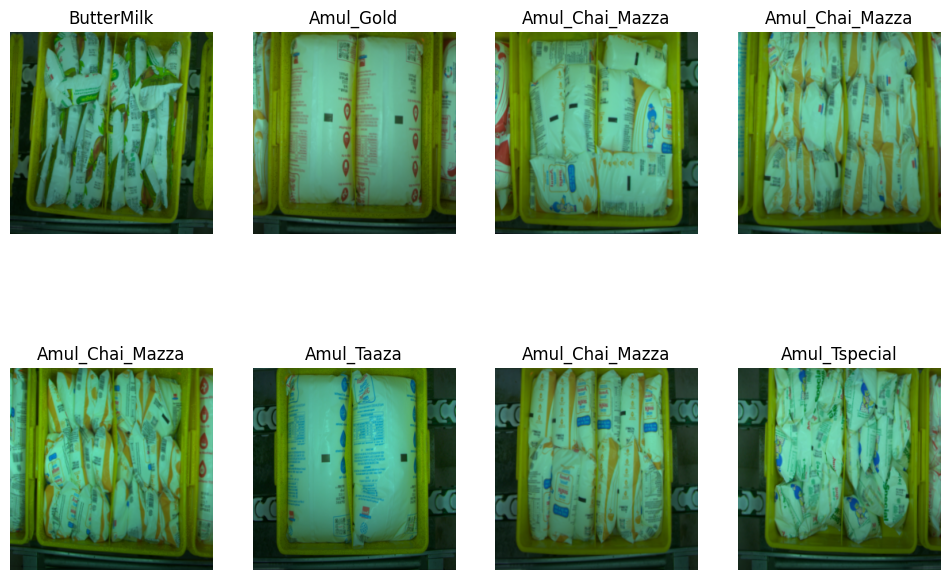

In [7]:
# DataBlock with balanced sampling and augmentations
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(256, method='squish')],
    batch_tfms=[
        *aug_transforms(
            mult=0.5,  # Reduce overall augmentation intensity
            do_flip=True,
            flip_vert=False,
            max_rotate=10.0,  # Reduced from 15
            max_zoom=1.15,    # Reduced from 1.3
            max_lighting=0.2, # Reduced from 0.4
            max_warp=0.1,     # Reduced from 0.3
            p_affine=0.5,     # Reduced probability
            p_lighting=0.5,
            xtra_tfms=[
                RandomResizedCrop(224, min_scale=0.7),  # Much less aggressive (was 0.3)
                Brightness(max_lighting=0.15, p=0.3),   # Reduced
                Contrast(max_lighting=0.15, p=0.3),
                Saturation(max_lighting=0.15, p=0.3),
            ]
        ),
        Normalize.from_stats(*imagenet_stats)
    ]
)

# Create dataloaders with smaller batch size for better generalization
dls = dblock.dataloaders(DATA_PATH, bs=16)  # Reduced from 32

# Show batch examples
dls.show_batch(max_n=8, figsize=(12, 8))


In [8]:
# Initialize model with transfer learning
# learn = vision_learner(
#     dls,
#     models.densenet201,  # Using DenseNet201 as requested
#     metrics=accuracy,
#     loss_func=nn.CrossEntropyLoss(weight=class_weights_tensor),  # Apply class weights
#     wd=0.01,  # Weight decay for regularization
#     pretrained=True  # Use pretrained weights
# )
learn = vision_learner(
    dls,
    models.densenet201,
    metrics=[accuracy, error_rate],  # Add error_rate for better monitoring
    loss_func=CrossEntropyLossFlat(),  # NO class weights since balanced
    wd=0.1,      # Stronger weight decay (was 0.01)
    ps=0.5,      # Stronger dropout (was 0.25)
    pretrained=True
)

# # Option A: ResNet34 (lighter, often better for small datasets)
# learn = vision_learner(
#     dls,
#     models.resnet34,
#     metrics=[accuracy, error_rate],
#     loss_func=CrossEntropyLossFlat(),
#     wd=0.05,
#     ps=0.3,
#     pretrained=True
# )

# # Option B: ConvNeXt Tiny (modern architecture, efficient)
# learn = vision_learner(
#     dls,
#     'convnext_tiny_in22k',
#     metrics=[accuracy, error_rate],
#     loss_func=CrossEntropyLossFlat(),
#     wd=0.05,
#     ps=0.3,
#     pretrained=True
# )

# # Option C: EfficientNet B0 (designed for efficiency)
# learn = vision_learner(
#     dls,
#     'efficientnet_b0',
#     metrics=[accuracy, error_rate],
#     loss_func=CrossEntropyLossFlat(),
#     wd=0.05,
#     ps=0.3,
#     pretrained=True
# )

# Check model architecture

learn.model

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


100%|██████████| 77.4M/77.4M [00:00<00:00, 239MB/s]


Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine

SuggestedLRs(valley=0.0012022644514217973)

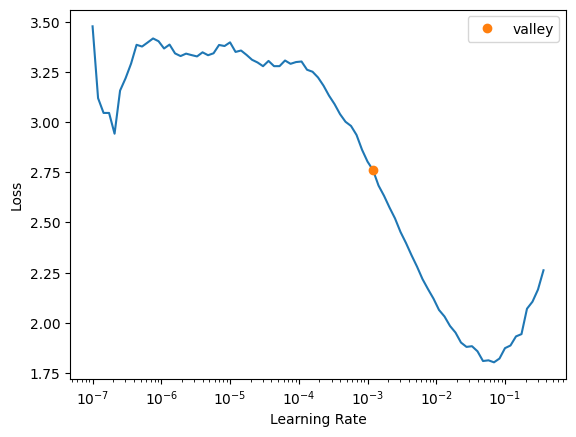

In [9]:
# Phase 1: Train only the head (frozen backbone)
learn.freeze()
learn.summary()

# Find optimal learning rate
learn.lr_find(show_plot=True)

In [10]:
# Train head with early stopping
learn.fit_one_cycle(
    15,  # Fewer epochs (was 25)
    lr_max=1e-5,  # Conservative starting point
    cbs=[
        EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5),
        SaveModelCallback(monitor='valid_loss', fname='stage1_best')
    ]
)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,3.285389,2.528642,0.152425,0.847575,00:54
1,2.938514,2.001860,0.265589,0.734411,00:26
2,2.302123,1.280617,0.496536,0.503464,00:26
3,1.605209,0.841580,0.699769,0.300231,00:27
4,1.212694,0.581372,0.817552,0.182448,00:27
5,0.987879,0.441850,0.877598,0.122402,00:27
6,0.817402,0.352767,0.898383,0.101617,00:26
7,0.737612,0.312814,0.896074,0.103926,00:27
8,0.632706,0.278361,0.919169,0.080831,00:27
9,0.559011,0.249110,0.933025,0.066975,00:27


Better model found at epoch 0 with valid_loss value: 2.528641939163208.
Better model found at epoch 1 with valid_loss value: 2.0018601417541504.
Better model found at epoch 2 with valid_loss value: 1.2806172370910645.
Better model found at epoch 3 with valid_loss value: 0.8415796160697937.
Better model found at epoch 4 with valid_loss value: 0.5813724994659424.
Better model found at epoch 5 with valid_loss value: 0.44185006618499756.
Better model found at epoch 6 with valid_loss value: 0.3527665436267853.
Better model found at epoch 7 with valid_loss value: 0.3128138482570648.
Better model found at epoch 8 with valid_loss value: 0.27836140990257263.
Better model found at epoch 9 with valid_loss value: 0.24911043047904968.
Better model found at epoch 10 with valid_loss value: 0.2488570362329483.
Better model found at epoch 11 with valid_loss value: 0.24150295555591583.
Better model found at epoch 13 with valid_loss value: 0.2370549440383911.
Better model found at epoch 14 with valid_los

In [ ]:
# Train head with early stopping
learn.fit_one_cycle(
    25,  # More epochs (was 15)
    lr_max=1e-5,  # Conservative starting point
    cbs=[
        EarlyStoppingCallback(monitor='valid_loss', min_delta=0.005, patience=2),
        SaveModelCallback(monitor='valid_loss', fname='stage1_best')
    ]
)

In [ ]:
# dls.show_batch()

SuggestedLRs(valley=0.0004786300996784121)

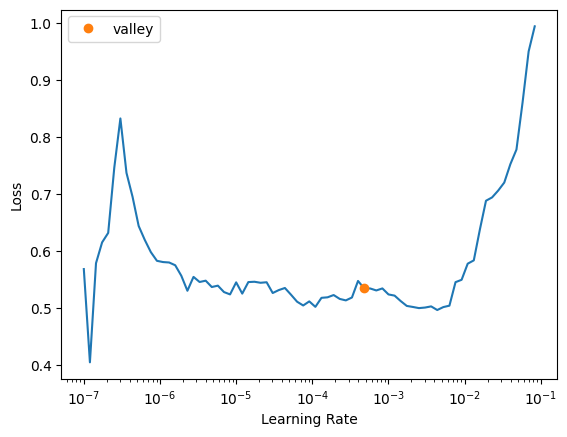

In [11]:
# Phase 2: Unfreeze and fine-tune entire model
learn.unfreeze()

# Find new learning rate range
learn.lr_find()

In [12]:
# Fine-tune with lower learning rates
learn.fit_one_cycle(
    30,  # Reduced from 60
    lr_max=slice(1e-7, 5.5e-7),  # Lower learning rates
    cbs=[
        EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=8),
        SaveModelCallback(monitor='valid_loss', fname='final_best')
    ]
)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.531530,0.229117,0.933025,0.066975,00:31
1,0.529158,0.239672,0.935335,0.064665,00:31
2,0.518550,0.234631,0.930716,0.069284,00:31
3,0.525478,0.230433,0.937644,0.062356,00:31
4,0.518750,0.239263,0.928406,0.071594,00:31
5,0.492753,0.239487,0.937644,0.062356,00:31
6,0.518229,0.222264,0.939954,0.060046,00:30
7,0.519035,0.222883,0.937644,0.062356,00:31
8,0.479505,0.223842,0.939954,0.060046,00:31


Better model found at epoch 0 with valid_loss value: 0.22911730408668518.
Better model found at epoch 6 with valid_loss value: 0.22226443886756897.
No improvement since epoch 0: early stopping


                 precision    recall  f1-score   support

Amul_Chai_Mazza       1.00      1.00      1.00        78
      Amul_Gold       1.00      1.00      1.00        61
    Amul_Shakti       0.72      0.95      0.82        62
       Amul_SnT       1.00      0.99      0.99        67
     Amul_Taaza       1.00      1.00      1.00        61
  Amul_Tspecial       0.87      0.48      0.62        42
     ButterMilk       1.00      1.00      1.00        62

       accuracy                           0.94       433
      macro avg       0.94      0.92      0.92       433
   weighted avg       0.95      0.94      0.94       433



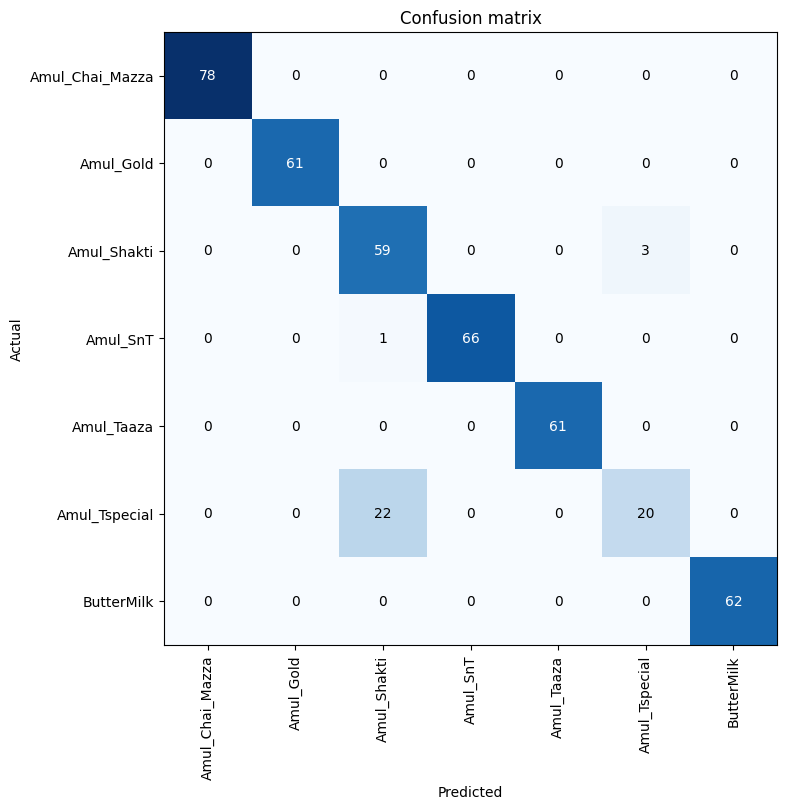

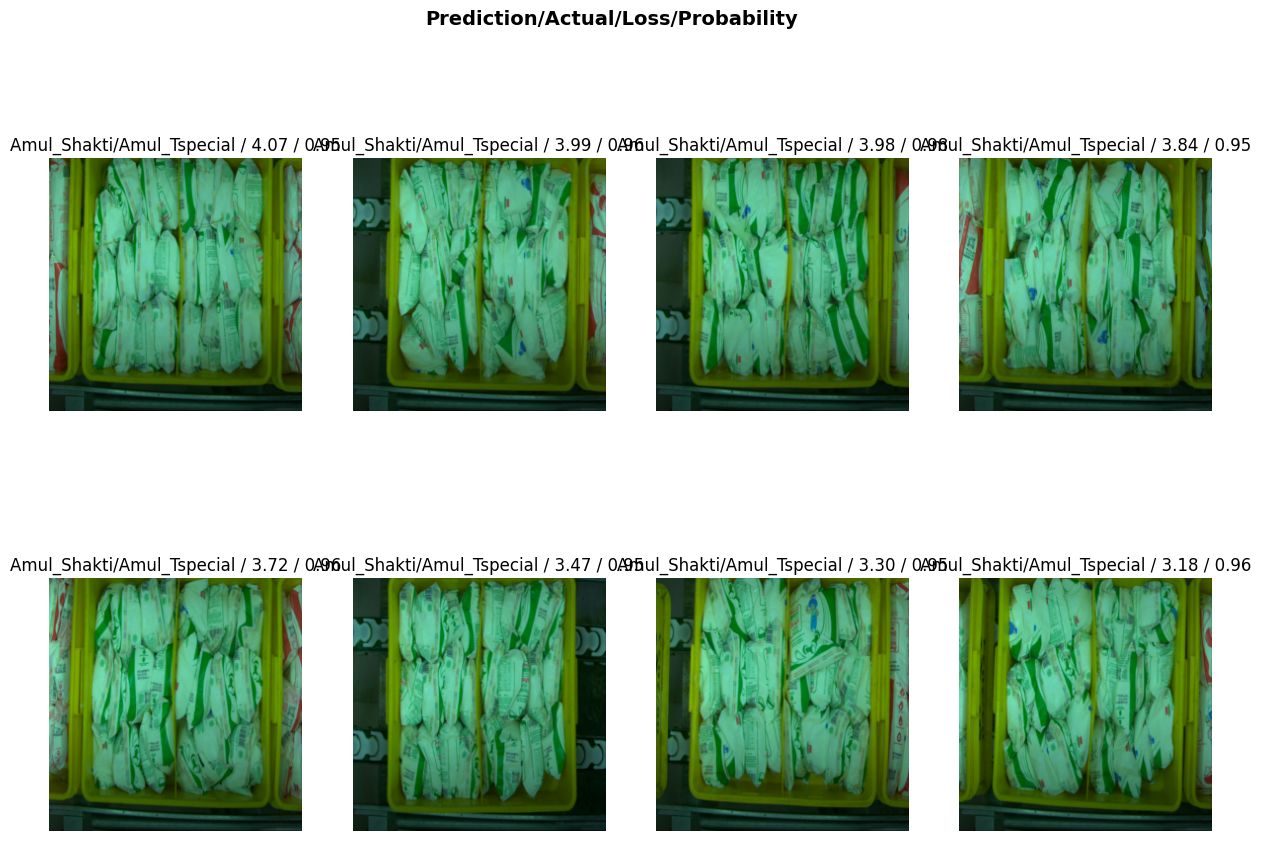

In [13]:
# Evaluate model performance
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8, 8))
interp.print_classification_report()

# Show top losses
interp.plot_top_losses(8, figsize=(15, 10))

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

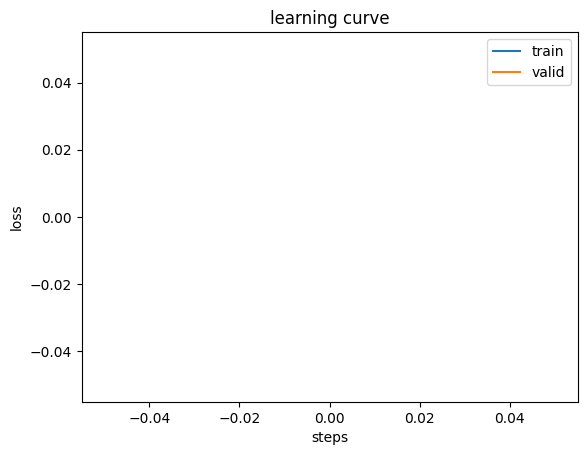

In [15]:
learn.recorder.plot_loss()

#Export

In [16]:
!pip install onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 133.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.5 MB/s eta 0:00:00


In [18]:
import torch
import onnx
import onnxruntime as ort
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

In [19]:
# ===========================
# 1. EXPORT FASTAI MODEL (PKL)
# ===========================
print("📦 Exporting FastAI model...")
learn.export('/content/drive/MyDrive/Satya_prompt/final_densenet201.pkl')
print("✅ FastAI model saved as .pkl")

📦 Exporting FastAI model...
✅ FastAI model saved as .pkl


In [20]:
# ===========================
# 2. EXPORT ONNX MODEL
# ===========================
print("\n🔧 Exporting ONNX model...")
try:
    # Prepare model for export
    learn.model.eval()
    dummy_input = torch.randn(1, 3, 224, 224).cuda()

    # Export to ONNX
    torch.onnx.export(
        learn.model.cuda(),
        dummy_input,
        '/content/drive/MyDrive/Satya_prompt/final_densenet201.onnx',
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
        opset_version=11,
        do_constant_folding=True
    )
    print("✅ ONNX model exported successfully!")

    # Verify ONNX model
    onnx_model = onnx.load('/content/drive/MyDrive/Satya_prompt/final_densenet201.onnx')
    onnx.checker.check_model(onnx_model)
    print("✅ ONNX model verified!")

except Exception as e:
    print(f"❌ ONNX export failed: {e}")


🔧 Exporting ONNX model...


/tmp/ipython-input-1181645556.py:11: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


✅ ONNX model exported successfully!
✅ ONNX model verified!



🧪 TESTING FASTAI MODEL (.pkl)



📸 Testing image: NET_11_1_side_09_10_2025_19_17_05_577.jpg
🎯 Predicted: Amul_Gold
📊 Confidence: 0.9983 (99.83%)

📋 All class probabilities:
  Amul_Chai_Mazza     : 0.0003 
  Amul_Gold           : 0.9983 █████████████████████████████████████████████████
  Amul_Shakti         : 0.0002 
  Amul_SnT            : 0.0006 
  Amul_Taaza          : 0.0002 
  Amul_Tspecial       : 0.0003 
  ButterMilk          : 0.0002 


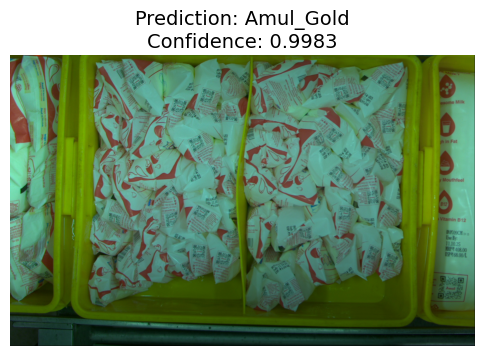

In [44]:
# ===========================
# 3. TEST FASTAI MODEL (.PKL)
# ===========================
print("\n" + "="*60)
print("🧪 TESTING FASTAI MODEL (.pkl)")
print("="*60)

# Load the exported model
learn_loaded = load_learner('/content/drive/MyDrive/Satya_prompt/final_densenet201.pkl')

def test_fastai_model(img_path, learn_model):
    """Test FastAI model with single image"""
    img = PILImage.create(img_path)

    # Regular prediction
    pred_class, pred_idx, outputs = learn_model.predict(img)
    confidence = outputs[pred_idx].item()

    print(f"\n📸 Testing image: {img_path.name}")
    print(f"🎯 Predicted: {pred_class}")
    print(f"📊 Confidence: {confidence:.4f} ({confidence*100:.2f}%)")
    print(f"\n📋 All class probabilities:")
    for idx, prob in enumerate(outputs):
        class_name = learn_model.dls.vocab[idx]
        bar = "█" * int(prob * 50)
        print(f"  {class_name:20s}: {prob:.4f} {bar}")

    # Display image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}\nConfidence: {confidence:.4f}", fontsize=14)
    plt.axis('off')
    plt.show()

    return pred_class, confidence

# Test on a single image
test_image_path = Path("/content/NET_11_1_side_09_10_2025_19_17_05_577.jpg")
# CHANGE THIS PATH TO YOUR TEST IMAGE

if test_image_path.exists():
    pred_class, conf = test_fastai_model(test_image_path, learn_loaded)
else:
    print(f"⚠️ Test image not found: {test_image_path}")
    print("Please update the test_image_path variable")


🧪 TESTING ONNX MODEL (.onnx)

📸 Testing image: NET_11_1_side_09_10_2025_19_17_05_577.jpg
🎯 Predicted: Amul_Gold
📊 Confidence: 0.8998 (89.98%)

📋 All class probabilities:
  Amul_Chai_Mazza     : 0.0002 
  Amul_Gold           : 0.8998 ████████████████████████████████████████████
  Amul_Shakti         : 0.0011 
  Amul_SnT            : 0.0908 ████
  Amul_Taaza          : 0.0020 
  Amul_Tspecial       : 0.0050 
  ButterMilk          : 0.0011 


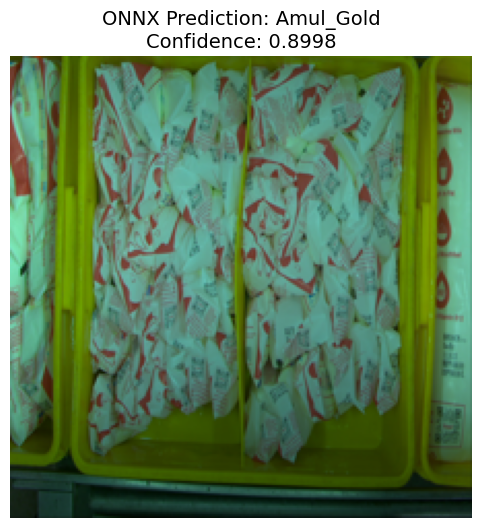

In [45]:
# ===========================
# 4. TEST ONNX MODEL
# ===========================
print("\n" + "="*60)
print("🧪 TESTING ONNX MODEL (.onnx)")
print("="*60)

def test_onnx_model(img_path, onnx_path, class_names):
    """Test ONNX model with single image"""

    # Load ONNX model
    ort_session = ort.InferenceSession(onnx_path)

    # Preprocess image (same as FastAI)
    img = Image.open(img_path).convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img).astype(np.float32) / 255.0

    # Normalize with ImageNet stats
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    img_array = (img_array - mean) / std

    # Transpose to CHW format and add batch dimension
    img_array = img_array.transpose(2, 0, 1)
    img_array = np.expand_dims(img_array, axis=0)

    # Run inference
    outputs = ort_session.run(None, {'input': img_array})[0]

    # Apply softmax to get probabilities
    exp_outputs = np.exp(outputs - np.max(outputs))
    probabilities = exp_outputs / exp_outputs.sum()

    # Get prediction
    pred_idx = np.argmax(probabilities)
    pred_class = class_names[pred_idx]
    confidence = probabilities[0][pred_idx]

    print(f"\n📸 Testing image: {img_path.name}")
    print(f"🎯 Predicted: {pred_class}")
    print(f"📊 Confidence: {confidence:.4f} ({confidence*100:.2f}%)")
    print(f"\n📋 All class probabilities:")
    for idx, prob in enumerate(probabilities[0]):
        class_name = class_names[idx]
        bar = "█" * int(prob * 50)
        print(f"  {class_name:20s}: {prob:.4f} {bar}")

    # Display image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"ONNX Prediction: {pred_class}\nConfidence: {confidence:.4f}", fontsize=14)
    plt.axis('off')
    plt.show()

    return pred_class, confidence

# Test ONNX model
onnx_model_path = '/content/drive/MyDrive/Satya_prompt/final_densenet201.onnx'
class_names = learn.dls.vocab  # ['Gold5ltr', 'ButterMilk450ml', etc.]

if Path(onnx_model_path).exists() and test_image_path.exists():
    pred_class_onnx, conf_onnx = test_onnx_model(
        test_image_path,
        onnx_model_path,
        class_names
    )
else:
    print(f"⚠️ ONNX model or test image not found")


In [38]:
# ===========================
# 5. BATCH TESTING ON FOLDER
# ===========================
print("\n" + "="*60)
print("🧪 BATCH TESTING ON TEST FOLDER")
print("="*60)

def batch_test_folder(test_folder, learn_model, use_tta=True):
    """Test model on all images in a folder"""
    test_folder = Path(test_folder)
    test_images = list(test_folder.glob("*.jpg")) + list(test_folder.glob("*.png"))

    if len(test_images) == 0:
        print(f"⚠️ No images found in {test_folder}")
        return

    print(f"\n📁 Found {len(test_images)} images in test folder")

    results = []
    correct = 0

    for img_path in test_images:
        try:
            # Extract true label from filename (if format is: label_xxx.jpg)
            # Adjust this based on your filename format
            true_label = img_path.stem.split("_")
            true_label = true_label[0] if len(true_label) == 2 else "_".join(true_label[:-1])
            # Predict
            img = PILImage.create(img_path)

            if use_tta:
                # Test-Time Augmentation for better accuracy
                preds, _ = learn_model.tta(dl=learn_model.dls.test_dl([img]))
                pred_idx = preds[0].argmax()
                confidence = preds[0][pred_idx].item()
                pred_class = learn_model.dls.vocab[pred_idx]
            else:
                pred_class, pred_idx, outputs = learn_model.predict(img)
                confidence = outputs[pred_idx].item()

            # Check accuracy if true label is known
            is_correct = (pred_class == true_label) if true_label else None
            if is_correct:
                correct += 1

            results.append({
                'filename': img_path.name,
                'true_label': true_label,
                'predicted': pred_class,
                'confidence': confidence,
                'correct': is_correct
            })

            print(f"✓ {img_path.name:30s}  → {pred_class:15s} → {true_label:15s} ({confidence:.3f})")

        except Exception as e:
            print(f"✗ Error processing {img_path.name}: {e}")

    # Summary
    print(f"\n{'='*60}")
    print(f"📊 SUMMARY")
    print(f"{'='*60}")
    print(f"Total images: {len(test_images)}")
    if any(r['correct'] is not None for r in results):
        total_labeled = sum(1 for r in results if r['correct'] is not None)
        accuracy = correct / total_labeled if total_labeled > 0 else 0
        print(f"Correctly predicted: {correct}/{total_labeled}")
        print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

    # Show low confidence predictions
    print(f"\n⚠️ Low confidence predictions (< 0.8):")
    low_conf = [r for r in results if r['confidence'] < 0.8]
    for r in low_conf:
        print(f"  {r['filename']:30s} → {r['predicted']:15s} ({r['confidence']:.3f})")

    return results

# Test on a folder
test_folder_path = "/content/drive/MyDrive/Satya_prompt/test_images"
# CHANGE THIS TO YOUR TEST FOLDER PATH

if Path(test_folder_path).exists():
    results = batch_test_folder(test_folder_path, learn_loaded, use_tta=True)
else:
    print(f"⚠️ Test folder not found: {test_folder_path}")
    print("Create a test folder and add images to test!")



🧪 BATCH TESTING ON TEST FOLDER

📁 Found 35 images in test folder


✓ ButterMilk_5.jpg                → ButterMilk      → ButterMilk      (0.990)


✓ ButterMilk_2.jpg                → ButterMilk      → ButterMilk      (0.997)


✓ ButterMilk_3.jpg                → ButterMilk      → ButterMilk      (0.997)


✓ ButterMilk_4.jpg                → ButterMilk      → ButterMilk      (0.995)


✓ ButterMilk_1.jpg                → ButterMilk      → ButterMilk      (0.979)


✓ Amul_Gold_2.jpg                 → Amul_Gold       → Amul_Gold       (0.994)
✗ Error processing Amul_Gol_5.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/Satya_prompt/test_images/Amul_Gol_5.jpg'


✓ Amul_Gold_1.jpg                 → Amul_Gold       → Amul_Gold       (1.000)


✓ Amul_Gold_4.jpg                 → Amul_Gold       → Amul_Gold       (0.969)


✓ Amul_Gold_3.jpg                 → Amul_Gold       → Amul_Gold       (0.990)


✓ Amul_Chai_Mazza_1.jpg           → Amul_Chai_Mazza → Amul_Chai_Mazza (0.954)


✓ Amul_Chai_Mazza_4.jpg           → Amul_Chai_Mazza → Amul_Chai_Mazza (0.882)


✓ Amul_Chai_Mazza_2.jpg           → Amul_Chai_Mazza → Amul_Chai_Mazza (0.993)


✓ Amul_Chai_Mazza_3.jpg           → Amul_Chai_Mazza → Amul_Chai_Mazza (0.876)


✓ Amul_Chai_Mazza_5.jpg           → Amul_Chai_Mazza → Amul_Chai_Mazza (0.836)


✓ Amul_SnT_2.jpg                  → Amul_SnT        → Amul_SnT        (0.999)


✓ Amul_SnT_3.jpg                  → Amul_SnT        → Amul_SnT        (0.998)


✓ Amul_SnT_4.jpg                  → Amul_SnT        → Amul_SnT        (1.000)


✓ Amul_SnT_1.jpg                  → Amul_SnT        → Amul_SnT        (0.996)


✓ Amul_SnT_5.jpg                  → Amul_SnT        → Amul_SnT        (0.972)


✓ Amul_Shakti_2.jpg               → Amul_Shakti     → Amul_Shakti     (0.959)


✓ Amul_Shakti_1.jpg               → Amul_Shakti     → Amul_Shakti     (0.725)


✓ Amul_Shakti_5.jpg               → Amul_Shakti     → Amul_Shakti     (0.903)


✓ Amul_Shakti_3.jpg               → Amul_Shakti     → Amul_Shakti     (0.847)


✓ Amul_Shakti_4.jpg               → Amul_Shakti     → Amul_Shakti     (0.888)


✓ Amul_Taaza_2.jpg                → Amul_Taaza      → Amul_Taaza      (0.993)


✓ Amul_Taaza_1.jpg                → Amul_Taaza      → Amul_Taaza      (0.994)


✓ Amul_Taaza_4.jpg                → Amul_Taaza      → Amul_Taaza      (0.983)


✓ Amul_Taaza_5.jpg                → Amul_Taaza      → Amul_Taaza      (0.998)


✓ Amul_Taaza_3.jpg                → Amul_Taaza      → Amul_Taaza      (0.996)


✓ Amul_Tspecial_2.jpg             → Amul_Tspecial   → Amul_Tspecial   (0.523)


✓ Amul_Tspecial_4.jpg             → Amul_Tspecial   → Amul_Tspecial   (0.655)


✓ Amul_Tspecial_1.jpg             → Amul_Chai_Mazza → Amul_Tspecial   (0.423)


✓ Amul_Tspecial_5.jpg             → Amul_Tspecial   → Amul_Tspecial   (0.796)


✓ Amul_Tspecial_3.jpg             → Amul_Tspecial   → Amul_Tspecial   (0.517)

📊 SUMMARY
Total images: 35
Correctly predicted: 33/34
Accuracy: 0.9706 (97.06%)

⚠️ Low confidence predictions (< 0.8):
  Amul_Shakti_1.jpg              → Amul_Shakti     (0.725)
  Amul_Tspecial_2.jpg            → Amul_Tspecial   (0.523)
  Amul_Tspecial_4.jpg            → Amul_Tspecial   (0.655)
  Amul_Tspecial_1.jpg            → Amul_Chai_Mazza (0.423)
  Amul_Tspecial_5.jpg            → Amul_Tspecial   (0.796)
  Amul_Tspecial_3.jpg            → Amul_Tspecial   (0.517)


In [46]:
# ===========================
# 6. COMPARE FASTAI vs ONNX
# ===========================
print("\n" + "="*60)
print("🔬 COMPARING FASTAI vs ONNX PREDICTIONS")
print("="*60)

def compare_models(img_path, fastai_model, onnx_path, class_names):
    """Compare FastAI and ONNX model predictions"""

    # FastAI prediction
    img = PILImage.create(img_path)
    pred_class_fastai, pred_idx_fastai, outputs_fastai = fastai_model.predict(img)
    conf_fastai = outputs_fastai[pred_idx_fastai].item()

    # ONNX prediction
    ort_session = ort.InferenceSession(onnx_path)
    img_pil = Image.open(img_path).convert('RGB').resize((224, 224))
    img_array = np.array(img_pil).astype(np.float32) / 255.0
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    img_array = (img_array - mean) / std
    img_array = img_array.transpose(2, 0, 1)[np.newaxis, ...]
    outputs_onnx = ort_session.run(None, {'input': img_array})[0]
    exp_outputs = np.exp(outputs_onnx - np.max(outputs_onnx))
    probabilities = exp_outputs / exp_outputs.sum()
    pred_idx_onnx = np.argmax(probabilities)
    pred_class_onnx = class_names[pred_idx_onnx]
    conf_onnx = probabilities[0][pred_idx_onnx]

    print(f"\n📸 Image: {img_path.name}")
    print(f"{'Model':<15} {'Prediction':<20} {'Confidence':<15} {'Match'}")
    print(f"{'-'*60}")
    print(f"{'FastAI':<15} {pred_class_fastai:<20} {conf_fastai:<15.4f}")
    print(f"{'ONNX':<15} {pred_class_onnx:<20} {conf_onnx:<15.4f} {'✓' if pred_class_fastai == pred_class_onnx else '✗'}")

    return pred_class_fastai == pred_class_onnx

if Path(onnx_model_path).exists() and test_image_path.exists():
    match = compare_models(test_image_path, learn_loaded, onnx_model_path, class_names)
    if match:
        print("\n✅ Both models agree on the prediction!")
    else:
        print("\n⚠️ Models disagree! Check preprocessing or export.")

print("\n" + "="*60)
print("✅ ALL TESTS COMPLETE!")
print("="*60)


🔬 COMPARING FASTAI vs ONNX PREDICTIONS



📸 Image: NET_11_1_side_09_10_2025_19_17_05_577.jpg
Model           Prediction           Confidence      Match
------------------------------------------------------------
FastAI          Amul_Gold            0.9983         
ONNX            Amul_Gold            0.8998          ✓

✅ Both models agree on the prediction!

✅ ALL TESTS COMPLETE!
